In [1]:
import re
from collections import Counter
from tqdm import tqdm_notebook
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pymorphy2
from nltk.stem import WordNetLemmatizer 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_df = pd.read_csv("train.csv")

train_df.head()

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False


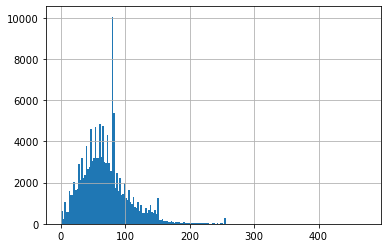

In [3]:
train_df.title.str.len().hist(bins=200);

In [4]:
train_df_ = train_df[((train_df['title'].apply(lambda x : len(x)>7)) | (train_df['title'].isin(['sex', 'porno', 'porn'])))\
         & (~train_df['title'].apply(lambda x : x.isdigit()))]

In [5]:
corpus_title = train_df_.title.values
corpus_url  = train_df_.url.values

In [7]:
def tokenize(text):
    TOKEN_PATTERN = "[а-яё]+"
    tokens = re.findall(TOKEN_PATTERN, text.lower())
    if len(tokens)==0:
        TOKEN_PATTERN = "[a-z]+"
        tokens = re.findall(TOKEN_PATTERN, text.lower())
        
    return tokens
docs_title = [tokenize(text) for text in corpus_title]
docs_url = [tokenize(text) for text in corpus_url]

In [7]:
lemmatizer_cache = {}
lemmatizer = pymorphy2.MorphAnalyzer()
lemmatizer_eng = WordNetLemmatizer()
stopword_set = set(nltk.corpus.stopwords.words('russian')+nltk.corpus.stopwords.words('english') + 
                   ['mail', 'ru', 'ua', 'www', 'com', 'net', 'kz', 'youla', 'cian', 'babyblog', 'hh',
                   'info', 'irecommend', 'm', 'org', 'by', 'info', 'xn', 'p', 'ai', 'su',  'b', 'd',
                   'studopedia', 'vseinstrumenti', 'en', 'uz', 'a', 'mp', 'cdn', 'v', 'cc', 's',
                'drom', 'spb', 'ampproject', 'sport', 'gdz', 'c', 'sp', 'citilink', 'mvideo', 'ucoz', 'in','gismeteo',
                   'blablacar', 'knigi', 'stoloto', 'books', 'pikabu', 'cyberleninka', 'news', 'superjob',
                   'az', 'e', 'ws', 'fm', 'в', 'на', 'и', 'с', 'для', 'по', 'а', 'тыс','у', 'без', 'ру', 'за',
                   'к', 'г', 'результатов', 'м', 'о', 'как', 'россия', 'olx'])

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    else:
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer_eng.lemmatize(token)
        return lemmatizer_cache[token]
    return token

lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs_title)]
cleared_docs_title = [[token for token in text if token not in stopword_set] for text in lemmatized_docs]
lemmatized_docs = []
lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs_url)]
cleared_docs_url = [[token for token in text if token not in stopword_set] for text in lemmatized_docs]
cleared_docs_url_ = [doc for doc in cleared_docs_url if len(doc)!=0]
cleared_docs_url = cleared_docs_url_

In [8]:
occurence = Counter()

for doc in cleared_docs_title:
    for token in doc:
        occurence[token] += 1

In [9]:
occurence.most_common(10)

[('онлайн', 11972),
 ('бесплатно', 8243),
 ('скачать', 7808),
 ('цена', 6923),
 ('купить', 6538),
 ('поиск', 6384),
 ('фото', 6373),
 ('смотреть', 6234),
 ('страница', 5940),
 ('порно', 5223)]

In [10]:
cooccurence = Counter()

for doc in cleared_docs_title:
    for i in range(len(doc) - 1):
        cooccurence[(doc[i], doc[i + 1])] += 1

In [11]:
cooccurence.most_common(10)

[(('смотреть', 'онлайн'), 3873),
 (('результат', 'поиск'), 3817),
 (('интернет', 'магазин'), 3079),
 (('скачать', 'бесплатно'), 2196),
 (('онлайн', 'бесплатно'), 2021),
 (('читать', 'онлайн'), 1826),
 (('порно', 'видео'), 1567),
 (('хороший', 'качество'), 1557),
 (('санкт', 'петербург'), 1397),
 (('цена', 'руб'), 1206)]

In [12]:
N = sum(occurence.values())

pmi = Counter()
min_cooccur = 5

for pair in cooccurence:
    if cooccurence[pair] >= min_cooccur:
        pmi[pair] = np.log(cooccurence[pair] * N / occurence[pair[0]] / occurence[pair[1]])

In [13]:
pmi_strings = []
for k  in pmi.keys():
    pmi_strings.append(' '.join(k))    

In [14]:
# lemmatizer_cache = {}
# lemmatizer = pymorphy2.MorphAnalyzer()
# stopword_set = set(nltk.corpus.stopwords.words('russian')+nltk.corpus.stopwords.words('english') + 
#                    ['mail', 'ru', 'ua', 'www', 'com', 'net', 'kz', 'youla', 'cian', 'babyblog', 'hh',
#                    'info', 'irecommend', 'm', 'org', 'by', 'info'])

# def lemmatize(token):
#     if lemmatizer.word_is_known(token):
#         if token not in lemmatizer_cache:
#             lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
#         return lemmatizer_cache[token]
    
#     return token

# lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs_title)]
# cleared_docs_title = [[token for token in text if token not in stopword_set] for text in lemmatized_docs]
# lemmatized_docs = []
# lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs_url)]
# cleared_docs_url = [[token for token in text if token not in stopword_set] for text in lemmatized_docs]
# cleared_docs_url_ = [doc for doc in cleared_docs_url if len(doc)!=0]
# cleared_docs_url = cleared_docs_url_

In [15]:
from sklearn.base import TransformerMixin


class ColumnExtractor(TransformerMixin):
    
    def __init__(self, column_name, need_pmi=False):
        if need_pmi:
            self.pmi = pmi_strings
        else:
            self.pmi = False
            self.column_name = column_name
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.pmi:
            return self.pmi
        else:
            return X[self.column_name].values

In [16]:
pipeline = Pipeline([
    (
        'features', 
        FeatureUnion([
            (
                'title_token', 
                Pipeline([
                    ('extractor', ColumnExtractor('title')),
                    (
                        'vectorizer1', 
                        TfidfVectorizer(# made countvect today 06.11.2020
                            lowercase=True, ngram_range=(3, 6),
                            stop_words=stopword_set, min_df=3, max_df=0.999, preprocessor=lemmatize
                        )
                    )
                ])
            ),
            (
                'title_char', 
                Pipeline([
                    ('extractor', ColumnExtractor('title')),
                    (
                        'vectorizer3', 
                        TfidfVectorizer(# made countvect today 06.11.2020
                            lowercase=True, ngram_range=(3, 6), analyzer='char',
                            stop_words=stopword_set, min_df=3, max_df=0.999, preprocessor=lemmatize
                        )
                    )
                ])
            ),
            #(
             #   'title_pmi', 
              #  Pipeline([
               #     ('extractor', ColumnExtractor('title', need_pmi=True)),
                #    (
                 #       'vectorizer5', 
                  #      CountVectorizer(lowercase=False)
                   # )
                #])
           # ),

            
            (
                'url_char',
                Pipeline([
                    ('extractor', ColumnExtractor('url')),
                    (
                        'vectorizer2', 
                        TfidfVectorizer(
                            lowercase=True, ngram_range=(3, 6),
                            stop_words=stopword_set, min_df=3, max_df=0.999, preprocessor=lemmatize, analyzer='char'
                        )
                    )
                ])
            ),
            (
                'url_token',
                Pipeline([
                    ('extractor', ColumnExtractor('url')),
                    (
                        'vectorizer4', 
                        TfidfVectorizer(
                            lowercase=True, ngram_range=(3, 6),
                            stop_words=stopword_set, min_df=3, max_df=0.999, preprocessor=lemmatize
                        )
                    )
                ])
            ),
        ])
    ),
    ('clf',  LogisticRegression(max_iter=5000, class_weight='balanced', penalty='l2'))
])

In [54]:
parameters = {# last best - contender
    #'features__title_token__vectorizer1__max_df': (0.999, 0.99),
    'features__title_token__vectorizer1__min_df': (29, 30),
    #'features__url_char__vectorizer2__max_df': (0.999, 0.99),
    'features__url_char__vectorizer2__min_df': (1, 0),
    #'features__url_token__vectorizer4__max_df': (0.999, 0.99),
    'features__url_token__vectorizer4__min_df': (34, 35),
    #'features__title_char__vectorizer3__max_df': (0.999, 0.99),
    'features__title_char__vectorizer3__min_df': (30, 29),
    #'clf__C': (0.9, 1)
}

In [55]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(train_df_, train_df_['target'].map({True: 1, False: 0}), test_size=0.2, random_state=42)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['target'].map({True: 1, False: 0}), test_size=0.2, random_state=42)

In [57]:
grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=1)

In [ ]:
grid_search.fit(X_train_, y_train_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


In [ ]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
cv_tuned_pipeline = grid_search.best_estimator_
f1_score(y_train_, cv_tuned_pipeline.predict(X_train_)), f1_score(y_test, cv_tuned_pipeline.predict(X_test)), f1_score(y_test_, cv_tuned_pipeline.predict(X_test_))

In [51]:
check = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(cv_tuned_pipeline.predict(X_test), columns=['preds'])], axis=1)
check[(check['target']!=check['preds']) & (check['target']==True)]

,id,url,title,target,preds
239,775,mail.ru,Екатерина Коба голая - 191 тыс. результатов. П...,True,0
607,102641,online.pochtabank.ru,Страница,True,0
663,4874,izbyshki.ru,Мокрые девчонки,True,0
2055,22445,3gpkings.info,38,True,0
2547,11830,beemtube.org,40,True,0
4155,9059,domahi.com,182,True,0
4336,97412,pt.carolchanning.net,As principais categorias de pedagogia são ... ...,True,0
4516,134174,sdamzavas.net,MS Excel в экономических расчетах,True,0
5105,60093,umijq.minme.info,Just a moment...,True,0
5352,46938,www.redwap.me,53,True,0


In [52]:
test_df = pd.read_csv("test.csv")

test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [53]:
test_df['target'] = cv_tuned_pipeline.predict(test_df).astype(bool)
test_df

,id,url,title,target
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...,False
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ...",False
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12,False
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ...",True
4,135313,2gis.ru,67,False
...,...,...,...,...
165373,300682,etp.armtek.ru,Armtek - запчасти для грузовых и легковых авто...,False
165374,300683,mail.ru,"Лилия Якупова - Караганда, Карагандинская обла...",False
165375,300684,xn----8sbnqchpeeeth.xn--p1ai,Администрация Лесного района Тверской области ...,False
165376,300685,www-sunhome-ru.cdn.ampproject.org,Сонник Изменение сознания. К чему снится Измен...,False


In [35]:
test_df[["id", "target"]].to_csv("submit15.csv", index=False)